In [1]:
#scientific libraries and plotting
import numpy as np
import scipy as scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import awkward as ak

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl
#Using newest versions of all libraries

In [2]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *

from resnet import ResNet18

In [3]:
#variables controlled by the user. Change these to fit your specific needs.
TEST_N_EVENTS = 3000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
RES = 50 #resolution
"""
#Data specification
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10"] #for plotting #"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", 
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9TEV", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH"]
"""

LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M10"]
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9TeV", "BH_n4_M10"] #for plotting 
CLASSES = 2 #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH"]

TEST_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(len(LABELS))] #The path to the folder containing the testing histogram files

MODEL_NAME = "resnet_1672847262"
LOAD_FOLDER = "/home/agrefsru/imcalML/results/models"
LOAD_PATH = f"{LOAD_FOLDER}/{MODEL_NAME}.pt"

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

ampl.use_atlas_style()   

Running on the GPU


In [4]:
#import model
model = ResNet18(img_channels=3, num_classes=CLASSES)
model.load_state_dict(torch.load(LOAD_PATH))
model.eval()
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), padding_mode=circular)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding_mode=circular)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding_mode=circular)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_siz

In [5]:
#Load data
sph_testpath = [Path(TEST_DATAPATHS[0])]
sph_test_data = Hdf5Dataset(sph_testpath, [TEST_LABELS[0]], DEVICE, 
                        shuffle=False, filters=None, transform=None, event_limit=TEST_N_EVENTS)

bh_testpath = [Path(TEST_DATAPATHS[1])]
bh_test_data = Hdf5Dataset(bh_testpath, [TEST_LABELS[1]], DEVICE, 
                        shuffle=False, filters=None, transform=None, event_limit=TEST_N_EVENTS)


In [6]:
truth, preds = predict(model, sph_test_data, CLASSES, 1, RES, DEVICE)
sph_df_3000 = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
truth, preds = predict(model, bh_test_data, CLASSES, 1, RES, DEVICE)
bh_df_3000 = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))

100%|██████████| 3000/3000 [00:21<00:00, 139.43it/s]


Text(0.5, 1.0, 'Sphaleron predictions')

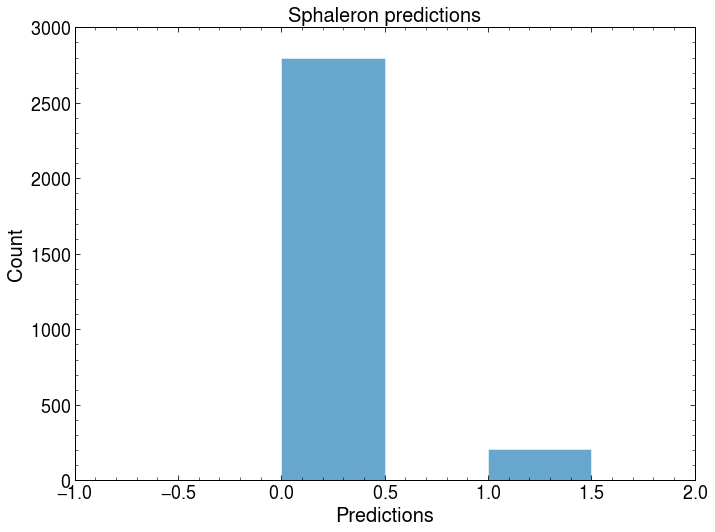

In [7]:
sn.histplot(sph_df_3000["Predictions"], binrange=(-0.5,1.5), binwidth=(0.5))
plt.title("Sphaleron predictions")

Text(0.5, 1.0, 'Black holes predictions')

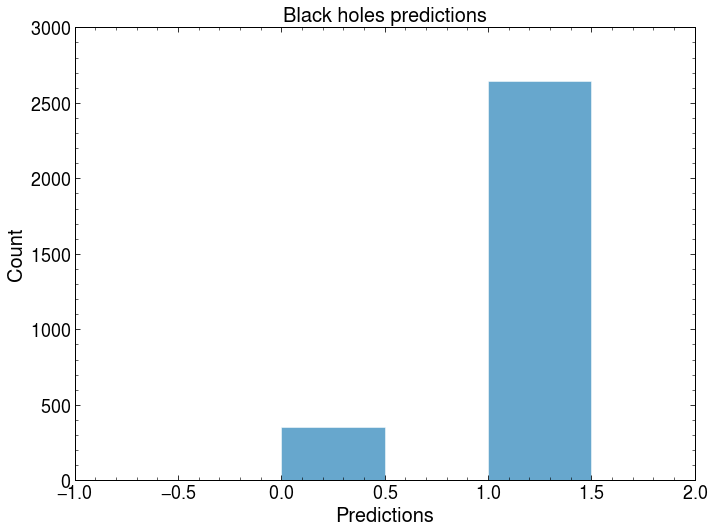

In [8]:
sn.histplot(bh_df_3000["Predictions"], binrange=(-0.5,1.5), binwidth=(0.5))
plt.title("Black holes predictions")

In [9]:
truth, preds = shuffle_predict(model, sph_test_data, CLASSES, 1, RES, DEVICE)
sph_df_shuffled = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
truth, preds = shuffle_predict(model, bh_test_data, CLASSES, 1, RES, DEVICE)
bh_df_shuffled = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))

100%|██████████| 3000/3000 [00:21<00:00, 142.71it/s]


Text(0.5, 1.0, 'Sphaleron 10 events predictions')

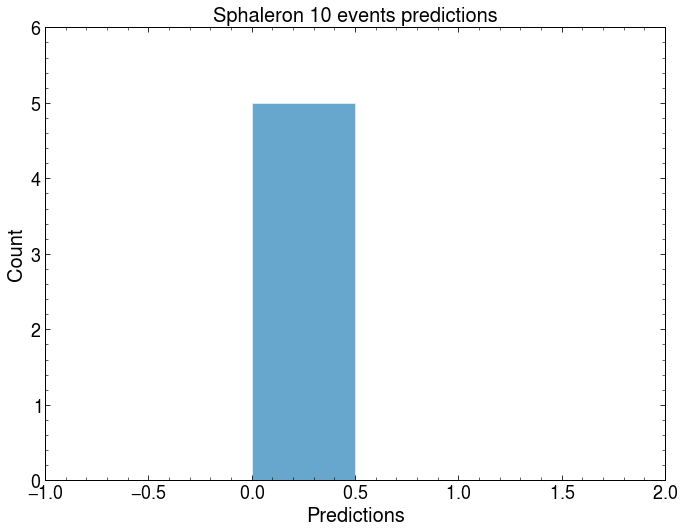

In [10]:
N = 5
k = np.random.randint(0, len(sph_df_shuffled)-N)
sn.histplot(sph_df_shuffled["Predictions"][k:k+N], binrange=(-0.5,1.5), binwidth=(0.5))
plt.title("Sphaleron 10 events predictions")

In [11]:
#chi2 test
from scipy import stats

def chi2(x, values):
    #Values is a 2xN vector, [data, theory]
    data = np.array(values[0])
    theory = np.array(values[1])
    return(np.sum([(x*data-theory)**2/(theory)]))

def chi2_method(sph, bh, data):
    
    #number of predicted particles in each class
    N_data_sph = len(data[data["Predictions"]==0])
    N_data_bh = len(data[data["Predictions"]==1])
    N_samp = len(data)

    #normalized predictions for theory 1 and 2 
    n_t1_sph = ((len(sph[sph["Predictions"]==0])/len(sph)))*N_samp 
    n_t1_bh = ((len(sph[sph["Predictions"]==1])/len(sph)))*N_samp 
    n_t2_sph = ((len(bh[bh["Predictions"]==0])/len(bh)))*N_samp 
    n_t2_bh = ((len(bh[bh["Predictions"]==1])/len(bh)))*N_samp 

    value_list1 = [[N_data_sph, N_data_bh], [n_t1_sph, n_t1_bh]]
    value_list2 = [[N_data_sph, N_data_bh], [n_t2_sph, n_t2_bh]]
    
    x_value1 = minimize(chi2, 0, value_list1).x[0]
    x_value2 = minimize(chi2, 0, value_list2).x[0]

    chi2_value1=chi2(x_value1, np.array(value_list1))
    chi2_value2=chi2(x_value2, np.array(value_list2))

    print(f"Histogram for data: {[N_data_sph, N_data_bh]}")
    print(f"Histogram sphaleron theory: {[n_t1_sph, n_t1_bh]}")
    print(f"The chi2 value for sphaleron theory is {chi2_value1}. The p-value is {1 - stats.chi2.cdf(chi2_value1, 1)}")
    print(f"Histogram black holes theory: {[n_t2_sph, n_t2_bh]}")
    print(f"The chi2 value for black holes theory is {chi2_value2}. The p-value is {1 - stats.chi2.cdf(chi2_value2, 1)}")


N = 80
k = np.random.randint(0, len(sph_df_shuffled)-N)
#send in theory 1 particles
experiment = sph_df_shuffled[k:k+N]
print("Sending in sphalerons")
chi2_method(sph_df_3000, bh_df_3000, experiment)


Sending in sphalerons
Histogram for data: [74, 6]
Histogram sphaleron theory: [74.56, 5.44]
The chi2 value for sphaleron theory is 0.06180528182893621. The p-value is 0.8036650400520989
Histogram black holes theory: [9.44, 70.56]
The chi2 value for black holes theory is 68.97682454572535. The p-value is 1.1102230246251565e-16
